In [1]:
%autosave 15
import numpy as np
import scipy as sc
import skimage as ski
import matplotlib.pyplot as plt


Autosaving every 15 seconds


C:\Users\Luke\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# 1.1

When doing the reconnaissance run on the raw file by excuting "dcraw -4 -d -v -w -T C:\Users\Luke\ISP_homework\data\baby.nef" in the terminal we get the following output.
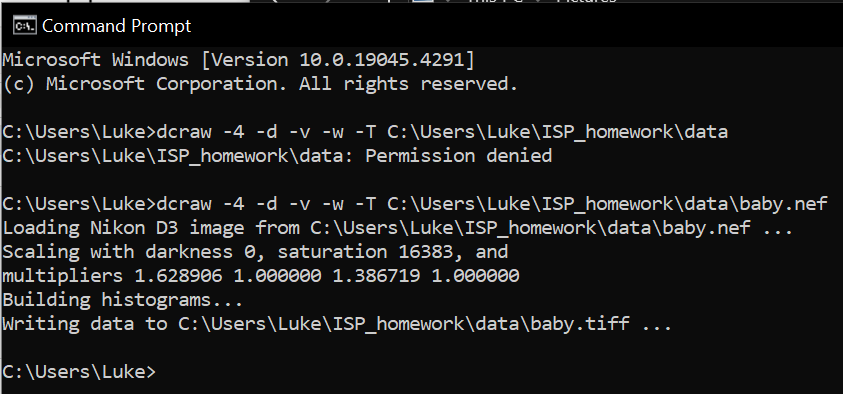

To create our .tiff file that we will use for the rest of the project, run "dcraw -4 -D -T C:\Users\Luke\ISP_homework\data\baby.nef" in the terminal.

In [2]:
black = 0
white = 16383
r_scale = 1.628906
g_scale1 = 1.000000
b_scale = 1.386719
g_scale2 = 1.000000

# Python Initials
We will be using skimage function imread for reading images. Originally,
it will be in the form of a numpy 2D-array of unsigned integers. Check and report how many bits per pixel
the image has, its width, and its height. Then, convert the image into a double-precision array. (See numpy
functions shape, dtype and astype.)

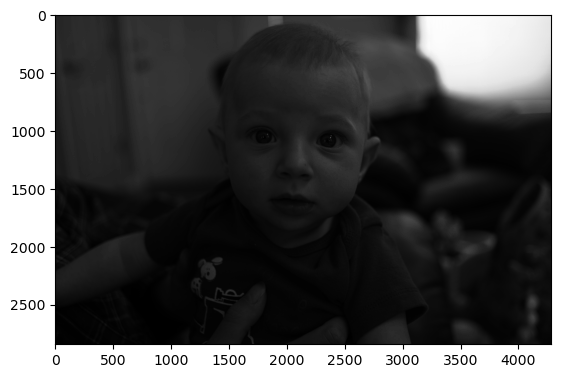

Original shape: (2844, 4284)


In [3]:
from skimage import io
image = io.imread('C:/Users/Luke/ISP_homework/data/baby.tiff')
plt.imshow(image, cmap='gray')
plt.show()
print("Original shape:", image.shape)

In [4]:
image_double = image.astype(np.float64)
print(image_double)

[[ 1755.  3004.  1704. ... 16327. 10520. 16307.]
 [ 3005.  2454.  3154. ... 16263. 16313. 16263.]
 [ 1688.  3040.  1710. ... 16327. 10379. 16306.]
 ...
 [  300.   230.   200. ...   118.   435.    97.]
 [  132.   210.   199. ...   399.   239.   433.]
 [  169.   152.   142. ...   121.   413.   121.]]


# Linearization
The 2D-array is not yet a linear image. As we discussed in class, it is possible
that it has an offset due to dark noise, and saturated pixels due to over-exposure. Additionally, even though
the original data-type of the image was 16 bits, only 14 of those have meaningful information, meaning that
the maximum possible value for pixels is 16; 383 (that's 2^14-1). For the provided image file, you can assume
the following: All pixels with a value lower than < black> correspond to pixels that would be black, were it
not for noise. All pixels with a value above < white> are saturated. The values < black> for the black level
and <white> for saturation are those you recorded earlier from the reconnaissance run of dcraw.
Convert the image into a linear array within the range [0; 1]. Do this by applying a linear transformation
(shift and scale) to the image, so that the value black is mapped to 0, and the value white is mapped
to 1. Then, clip negative values to 0, and values greater than 1 to 1. (See numpy function clip.)

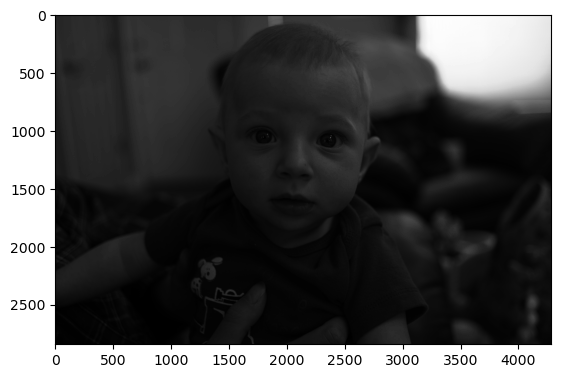

[[0.10712324 0.1833608  0.10401025 ... 0.99658182 0.64212904 0.99536104]
 [0.18342184 0.14978942 0.19251663 ... 0.99267533 0.99572728 0.99267533]
 [0.10303363 0.1855582  0.10437649 ... 0.99658182 0.63352255 0.99530001]
 ...
 [0.01831166 0.01403894 0.01220778 ... 0.00720259 0.02655191 0.00592077]
 [0.00805713 0.01281817 0.01214674 ... 0.02435451 0.01458829 0.02642984]
 [0.01031557 0.00927791 0.00866752 ... 0.0073857  0.02520906 0.0073857 ]]


In [5]:
image_linear = (image_double - black) / (white - black)
image_linear = np.clip(image_linear, 0, 1)
plt.imshow(image_linear, cmap='gray')
plt.show()
print(image_linear)

# Identifying the correct Bayer pattern

The bayer pattern that applies to this image is rggb. I identified this by going into a photo editor and zooming into the top left corner of the image.

In [6]:
bayer_pattern = 'RGGB'

# White Balancing
After identifying the correct Bayer pattern, we want to perform white
balancing. Implement both the white world and gray world white balancing algorithms, as discussed in
2
class. Additionally, implement a third white balancing algorithm, where you multiply the red, green, and blue
channels with the < r scale>, < g scale>, and < b scale> values you recorded earlier from the reconnaissance
run of dcraw. These values are the white balancing presets the camera uses. After completing the entire
developing process, check what the image looks like when using each of the three white balancing algorithms,
decide which one you like best, and report your choice. (See numpy functions max and mean.)

In [7]:
def simple_demosaic(image, pattern):
    R = image[0::2, 0::2] 
    G = image[0::2, 1::2] * 0.5 + image[1::2, 0::2] * 0.5
    B = image[1::2, 1::2]
    return np.dstack((R, G, B))

image_demosaiced = simple_demosaic(image_linear, bayer_pattern)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


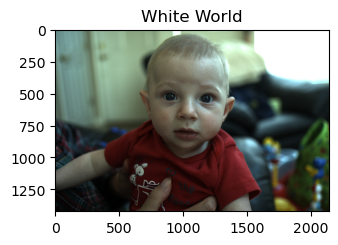

In [8]:
def white_world_balance(image):
    avg_color = np.mean(image, axis=(0, 1))
    scale_factors = (0.5 / avg_color)  
    return image * scale_factors[None, None, :]  

image_white_world = white_world_balance(image_demosaiced.copy())

plt.figure(figsize=(12, 6))
plt.subplot(131), plt.imshow(image_white_world), plt.title('White World')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


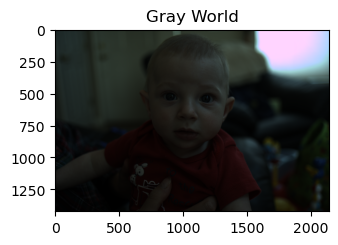

In [9]:
def gray_world_balance(image):
    avg_color = np.mean(image, axis=(0, 1))
    scale_factors = np.mean(avg_color) / avg_color  
    return image * scale_factors[None, None, :]

image_gray_world = gray_world_balance(image_demosaiced.copy())

plt.figure(figsize=(12, 6))
plt.subplot(132), plt.imshow(image_gray_world), plt.title('Gray World')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


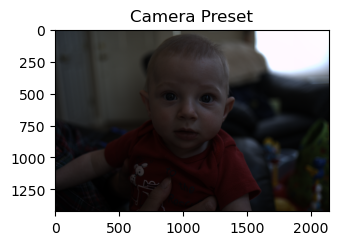

In [10]:
def camera_preset_balance(image):
    scale_factors = np.array([r_scale, g_scale1, b_scale]) 
    return image * scale_factors[None, None, :]

image_camera_preset = camera_preset_balance(image_demosaiced.copy())

plt.figure(figsize=(12, 6))
plt.subplot(133), plt.imshow(image_camera_preset), plt.title('Camera Preset')
plt.show()

From these 3 white balancing algorithms I will be using the image from the white world white balancing.

# Demosaicing
Once white balancing is done, it is time to demosaic the image. Use bilinear
interpolation for demosaicing, as discussed in class. Do not implement bilinear interpolation on your own!
Instead, use scipy's built-in interp2d function.

C:\Users\Luke\AppData\Local\Temp\ipykernel_22824\417936760.py:14: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  r_interp = interp2d(x[::2], y[::2], R, kind='linear')
C:\Users\Luke\AppData\Local\Temp\ipykernel_22824\417936760.py:15: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for re

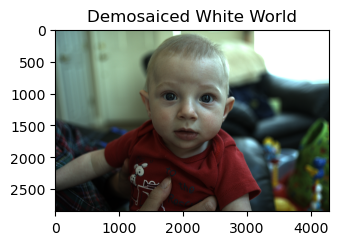

In [11]:
from scipy.interpolate import interp2d

def bilinear_demosaic(image, pattern):
    h, w = image.shape
    x, y = np.arange(0, w), np.arange(0, h)

    # Separate color channels
    R = image[0::2, 0::2]
    G1 = image[0::2, 1::2]
    G2 = image[1::2, 0::2] 
    B = image[1::2, 1::2]

    # Interpolation functions for each channel
    r_interp = interp2d(x[::2], y[::2], R, kind='linear')
    g1_interp = interp2d(x[::2], y[1::2], G1, kind='linear')
    g2_interp = interp2d(x[1::2], y[::2], G2, kind='linear')
    b_interp = interp2d(x[1::2], y[1::2], B, kind='linear')

    # Interpolate all pixels
    R_new = r_interp(x, y)
    G_new = (g1_interp(x, y) + g2_interp(x, y)) / 2
    B_new = b_interp(x, y)

    return np.dstack((R_new, G_new, B_new))

image_demosaiced = bilinear_demosaic(image_linear, bayer_pattern)

demosaiced_white_world = white_world_balance(image_demosaiced.copy())

plt.figure(figsize=(12, 6))
plt.subplot(131), plt.imshow(demosaiced_white_world), plt.title('Demosaiced White World')
plt.show()

# Color space correction


I retrieved the 1x9 array  [6988,-1384,-714,-5631,13410,2447,-1485,2204,7318] from dcraw's raw code for the Nikon D3400 to use for the color correction process

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


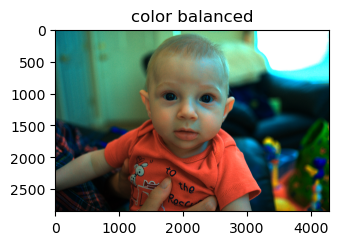

In [12]:
M_XYZ_cam = np.array([ 6988/10000,-1384/10000,-714/10000,-5631/10000,13410/10000,2447/10000,-1485/10000,2204/10000,7318/10000]).reshape(3, 3)

M_sRGB_XYZ = np.array([
    [0.4124564, 0.3575761, 0.1804375],
    [0.2126729, 0.7151522, 0.0721750],
    [0.0193339, 0.1191920, 0.9503041]
])
M_sRGB_cam = np.dot(M_sRGB_XYZ, M_XYZ_cam)

M_sRGB_cam /= np.sum(M_sRGB_cam, axis=1, keepdims=True) 

M_sRGB_cam_inv = np.linalg.inv(M_sRGB_cam)

image_color_balanced = np.zeros_like(demosaiced_white_world)
for i in range(demosaiced_white_world.shape[0]):
    for j in range(demosaiced_white_world.shape[1]):
        pixel_cam = demosaiced_white_world[i, j].reshape(3, 1) 
        pixel_srgb = np.dot(M_sRGB_cam_inv, pixel_cam).reshape(3)
        image_color_balanced[i, j] = pixel_srgb
        
plt.figure(figsize=(12, 6))
plt.subplot(131), plt.imshow(image_color_balanced), plt.title('color balanced')
plt.show()

# Brightness adjustment 

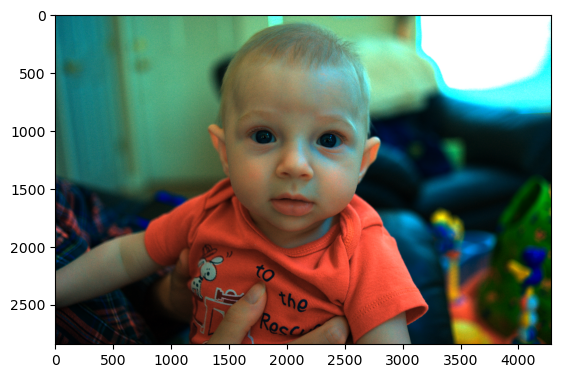

In [13]:
def brightness_adjustment(image, desired_mean_intensity):
    """Adjusts the brightness of a linear RGB image."""

    # Convert to grayscale
    image_grayscale = ski.color.rgb2gray(image)

    # Calculate current mean intensity
    current_mean_intensity = np.mean(image)

    # Calculate the scale factor
    scale_factor = desired_mean_intensity / current_mean_intensity

    # Scale the image (apply to all color channels)
    image_adjusted = image * scale_factor

    # Clip values to ensure they are within [0, 1]
    image_adjusted = np.clip(image_adjusted, 0, 1, out=image_adjusted)

    return image_adjusted

# ... (Call the function to apply brightness adjustment)
image_brightened = brightness_adjustment(image_color_balanced, .5)

plt.imshow(image_brightened)
plt.show()

# Gamma encoding

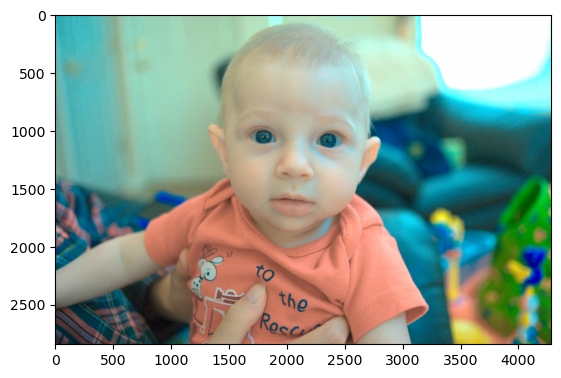

In [14]:
def gamma_encode(C_linear):
    a = 0.055
    C_nonlinear = np.where(C_linear <= 0.0031308, 12.92 * C_linear,
                           (1 + a) * np.power(C_linear, 1/2.4) - a) 
    return C_nonlinear
    
image_gamma_encoded = np.zeros_like(image_brightened)
for i in range(image_brightened.shape[0]):
    for j in range(image_brightened.shape[1]):
        image_gamma_encoded[i, j] = gamma_encode(image_brightened[i, j])

plt.imshow(image_gamma_encoded)
plt.show()

# Compression
Finally, it is time to store the image, either with or without compression. Use
skimage function imsave to store the image in .PNG format (no compression), and also in .JPEG format
with the quality parameter set to 95. This setting determines the amount of compression. Can you tell the
difference between the two files? The compression ratio is the ratio between the size of the uncompressed
file (in bytes) and the size of the compressed file (in bytes). What is the compression ratio?
By changing the JPEG quality settings, determine the lowest setting for which the compressed image is
indistinguishable from the original. What is the compression ratio?

In [19]:
ski.io.imsave('image_processed.png', image_gamma_encoded) 
ski.io.imsave('image_processed.jpg', image_gamma_encoded, quality=95) 

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [18]:
# PNG size/ JPEG size with quality parameter set to 95
compression_ratio = 17239622/4051692
print(compression_ratio)

4.254919179444045


In [19]:
#PNG size / JPEG size with quality parameter set to 20
low_compression_ratio = 17239622/361147
print(low_compression_ratio)

47.73574749340296


# second white balancing picture (gray world)

In [81]:
demosaiced_gray_world = gray_world_balance(image_demosaiced.copy())
image_color_balanced = np.zeros_like(demosaiced_gray_world)
for i in range(demosaiced_gray_world.shape[0]):
    for j in range(demosaiced_gray_world.shape[1]):
        pixel_cam = demosaiced_gray_world[i, j].reshape(3, 1) 
        pixel_srgb = np.dot(M_sRGB_cam_inv, pixel_cam).reshape(3)
        image_color_balanced[i, j] = pixel_srgb
        
image_brightened = brightness_adjustment(image_color_balanced, .5)
image_gamma_encoded = np.zeros_like(image_brightened)
for i in range(image_brightened.shape[0]):
    for j in range(image_brightened.shape[1]):
        image_gamma_encoded[i, j] = gamma_encode(image_brightened[i, j])
        
ski.io.imsave('image_processed_gray_world.png', image_gamma_encoded)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


# Manual white balancing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


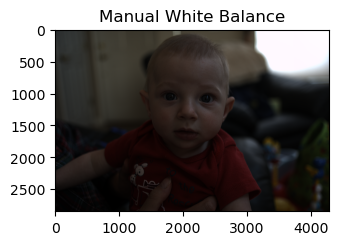

Lossy conversion from float64 to uint8. Range [0.0, 1.7148423504120385]. Convert image to uint8 prior to saving to suppress this warning.


In [42]:
def select_white_patch(image):
    x = 700   
    y = 4200
    return np.array([x, y]).astype(int) 

def manual_white_balance(image, white_patch_coords):
    x, y = white_patch_coords
    white_patch_color = image[x, y]

    scale_factors = white_patch_color.max() / white_patch_color

    return image * scale_factors[None, None, :]

white_patch_coords = select_white_patch(image_demosaiced.copy())
image_manual_wb = manual_white_balance(image_demosaiced.copy(), white_patch_coords)

plt.figure(figsize=(12, 6))
plt.subplot(132), plt.imshow(image_manual_wb), plt.title('Manual White Balance')
plt.show()

ski.io.imsave('image_manual_white_balancing.png', image_manual_wb)